In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import nltk
from nltk.corpus import stopwords

In [2]:
data = pd.read_csv('data.csv')
data = data.sample(frac = 1)
data.head()

,URLs,Headline,Body,Label
2588,http://beforeitsnews.com/sports/2017/09/jets-p...,Jets Place Charone Peake on IR,Jets Place Charone Peake on IR\n% of readers t...,0
1145,http://www.bbc.com/news/world-africa-41580041\n,Deadly 'supercell' storm scatters ships in Sou...,Image copyright Blue Security via Reuters Imag...,1
3465,http://money.cnn.com/2017/10/04/news/trump-mic...,Mick Mulvaney: Don't take Trump 'word for word...,One day after President Trump suggested that P...,1
1464,http://beforeitsnews.com/sports/2017/10/gateke...,Gatekeeper Invades The 312 Podcastto Preview t...,Gatekeeper Invades The 312 Podcastto Preview t...,0
725,http://www.cnn.com/2017/10/05/opinions/china-p...,US should hold China accountable on human rights,Story highlights Marco Rubio and Chris Smith: ...,1


In [3]:
data['Length'] = [len(headline) for headline in data['Headline']]
data.head()

,URLs,Headline,Body,Label,Length
2588,http://beforeitsnews.com/sports/2017/09/jets-p...,Jets Place Charone Peake on IR,Jets Place Charone Peake on IR\n% of readers t...,0,30
1145,http://www.bbc.com/news/world-africa-41580041\n,Deadly 'supercell' storm scatters ships in Sou...,Image copyright Blue Security via Reuters Imag...,1,55
3465,http://money.cnn.com/2017/10/04/news/trump-mic...,Mick Mulvaney: Don't take Trump 'word for word...,One day after President Trump suggested that P...,1,67
1464,http://beforeitsnews.com/sports/2017/10/gateke...,Gatekeeper Invades The 312 Podcastto Preview t...,Gatekeeper Invades The 312 Podcastto Preview t...,0,66
725,http://www.cnn.com/2017/10/05/opinions/china-p...,US should hold China accountable on human rights,Story highlights Marco Rubio and Chris Smith: ...,1,48


In [4]:
data['Length'].describe()

count    4009.000000
mean       60.104016
std        22.660900
min         6.000000
25%        48.000000
50%        60.000000
75%        69.000000
max       653.000000
Name: Length, dtype: float64

In [5]:
real_text = ' '.join(data[data['Label'] == 1]['Headline'])
fake_text = ' '.join(data[data['Label'] == 0]['Headline'])
fake_words = [word for word in nltk.tokenize.word_tokenize(fake_text) if word not in stopwords.words('english') and len(word) > 3]
real_words = [word for word in nltk.tokenize.word_tokenize(real_text) if word not in stopwords.words('english') and len(word) > 3]

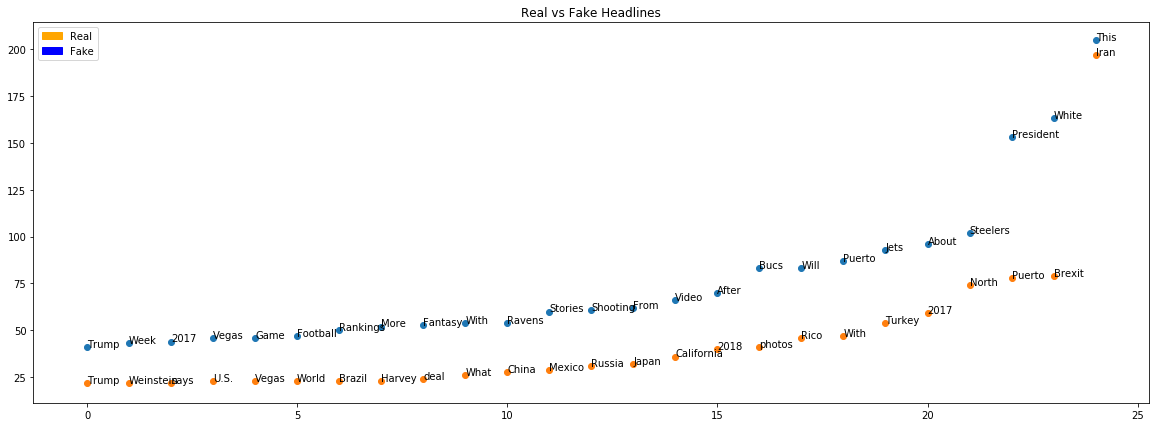

In [6]:
common_fake =nltk.FreqDist(fake_words).most_common(25)
common_real =nltk.FreqDist(real_words).most_common(25)
fake_ranks = []
fake_counts = []
real_ranks = []
real_counts = []

for ii, word in enumerate(reversed(common_fake)):
    fake_ranks.append(ii)
    fake_counts.append(word[1])

for ii, word in enumerate(reversed(common_real)):
    real_ranks.append(ii)
    real_counts.append(word[1])

plt.figure(figsize=(20, 7))

plt.scatter(fake_ranks, fake_counts)

for labels, fake_rank, fake_count in zip(common_fake, fake_ranks, fake_counts):
    plt.annotate(
        labels[0],
        xy = (fake_rank, fake_count)
    )

plt.scatter(real_ranks, real_counts)
plt.title('Real vs Fake Headlines')

for labels, real_rank, real_count in zip(common_real, real_ranks, real_counts):
    plt.annotate(
        labels[0],
        xy = (real_rank, real_count)
    )
    
real_patch = mpatches.Patch(color='orange', label='Real')
fake_patch = mpatches.Patch(color='blue', label='Fake')
plt.legend(handles=[real_patch, fake_patch])

plt.show()

In [7]:
def pad(x):
    
    if len(x) < 69:
        
        return x + ' ' * (69 - len(x))
    
    return x

def trim(x):
    
    if len(x) > 69:
        
        return x[:69]
    
    return x

data['Headline'] = data['Headline'].apply(pad)
data['Headline'] = data['Headline'].apply(trim)
data['Length'] = [len(headline) for headline in data['Headline']]
data.describe()

,Label,Length
count,4009.000000,4009.0
mean,0.466949,69.0
std,0.498969,0.0
min,0.000000,69.0
25%,0.000000,69.0
50%,0.000000,69.0
75%,1.000000,69.0
max,1.000000,69.0


In [8]:
text = ' '.join(data['Headline'])
dictionary_size = len(set(text))
dictionary = sorted(set(text))
character_map = { k:v for v, k in enumerate(dictionary) }
max_length = 69
batch_size = 50

In [9]:
def to_input(sentence, character_map, dictionary_size):
    
    sentence = np.array([character_map[char] for char in sentence])
    one_hot = np.zeros((len(sentence), dictionary_size))
    one_hot[np.arange(len(sentence)), sentence] = 1
    return one_hot

def batch(sentences, labels, start, batch_size):
    
    if start + batch_size < len(sentences):
        
        inputs = [to_input(sentence, character_map, dictionary_size) for sentence in sentences[start: start + batch_size ]]
        labels = [label for label in labels[start: start + batch_size ]]
        start = start + batch_size
    
    else:
        
        inputs = [to_input(sentence, character_map, dictionary_size) for sentence in sentences[start:]]
        labels = [label for label in labels[start:]]
        start = 0
    
    return np.array(inputs), np.array(labels) , start

def test_batch(sentences, labels):
    
        
    inputs = [to_input(sentence, character_map, dictionary_size) for sentence in sentences]
    labels = [label for label in labels]

    return np.array(inputs), np.array(labels)

In [10]:
inputs = tf.placeholder(tf.float32, [None, max_length, dictionary_size])
labels = tf.placeholder(tf.int64, [None])
hidden_size = 512
cell = tf.contrib.rnn.LSTMCell(hidden_size, state_is_tuple = True)
initial_state = tf.contrib.rnn.LSTMStateTuple(tf.placeholder(tf.float32, [None, hidden_size], name = "c_init"), 
                                             tf.placeholder(tf.float32, [None, hidden_size], name = "h_init"))

with tf.variable_scope("softmax") as softmax:
    
    W_h = tf.get_variable("Wh", 
        shape = [hidden_size, 2], 
        dtype = tf.float32,
        initializer = tf.random_normal_initializer(.1)
    )

    b_h = tf.get_variable("bh", 
        shape = 2,
        dtype = tf.float32,
        initializer = tf.ones_initializer()
    )

outputs, state = tf.nn.dynamic_rnn(cell, inputs, initial_state = initial_state)

logits = tf.matmul(outputs[:,-1, :], W_h) + b_h

loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels = labels, logits = logits
    )
)

accuracy = tf.reduce_mean(
    tf.cast(tf.equal(
        tf.argmax(logits, 1),
        tf.cast(labels, tf.int64)
    ), 
    tf.float32)
)

optimizer = tf.train.AdamOptimizer(.001)

train_step = optimizer.minimize(loss)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


In [11]:
with tf.Session() as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    initial = sess.run(cell.zero_state(50, tf.float32))

    start = 0
    inputs_, targets_, start = batch(data["Headline"][:3350], data["Label"][:3350], start, batch_size)
    
    for step in range(1000):
        _, initial = sess.run([train_step, initial_state], feed_dict = {
            inputs:inputs_, 
            labels:targets_,
            initial_state:initial
        })
        
        inputs_, targets_, start = batch(data["Headline"][:3350], data["Label"][:3350], start, batch_size)
        
            
        if step % 100 == 0:
            
            test_inputs, test_targets = test_batch(data["Headline"][3350:], data["Label"][3350:])
            cost, acc = sess.run([loss, accuracy], feed_dict = {
            inputs:test_inputs, 
            labels:test_targets,
            initial_state:sess.run(cell.zero_state(len(data["Label"][3350:]), tf.float32))
            })
            
            print(cost, acc)

2.4395325 0.45371777
0.4040156 0.8209408
0.47438613 0.7496206
0.40415516 0.80880123
0.47462678 0.7754173
0.4794777 0.7814871
0.40894318 0.80424887
0.39659548 0.83915025
0.36958385 0.84066767
0.5625568 0.7784522
